<a href="https://colab.research.google.com/github/cshooon/MovieRecommendation/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import random

In [ ]:
class MovieLens(Dataset):
    def __init__(self, user_tensor, item_tensor, target_tensor):
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.user_tensor.size(0)

def load_and_sample_data(csv_file, frac=0.5):
    df = pd.read_csv(csv_file)
    df = df.sample(frac=frac, random_state=42)
    return df

ratings_path = '/content/drive/MyDrive/data/ratings.csv'
movies_path = '/content/drive/MyDrive/data/movies.csv'

ratings = load_and_sample_data(ratings_path)
movies = load_and_sample_data(movies_path)

# 영화 정보와 평점 정보를 결합
full_data = pd.merge(ratings, movies, on='movieId', how='left')

# 타임스탬프를 기준으로 데이터를 분할하여 트레이닝, 검증, 테스트 세트를 생성
full_data_sorted = full_data.sort_values('timestamp')
train_cutoff = int(0.8 * len(full_data_sorted))
val_cutoff = int(0.9 * len(full_data_sorted))

train_df = full_data_sorted[:train_cutoff].copy()
validation_df = full_data_sorted[train_cutoff:val_cutoff].copy()
test_df = full_data_sorted[val_cutoff:].copy()

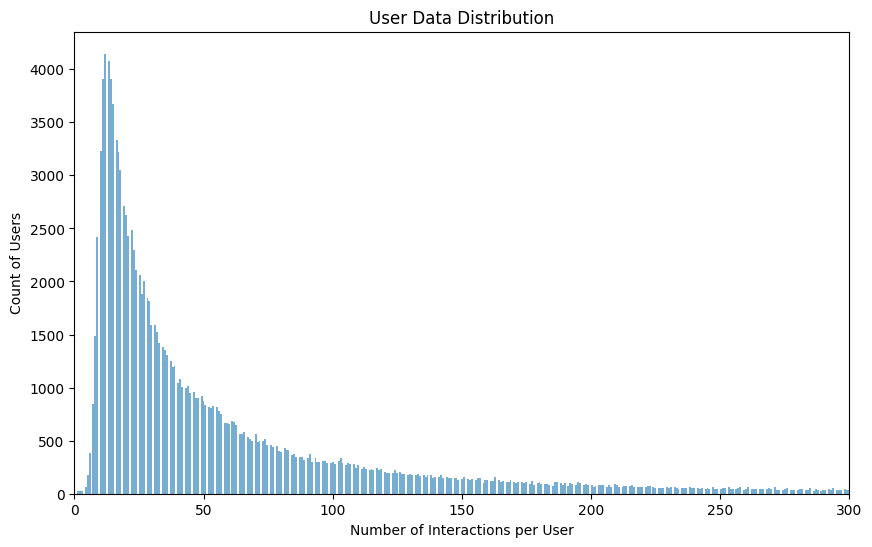

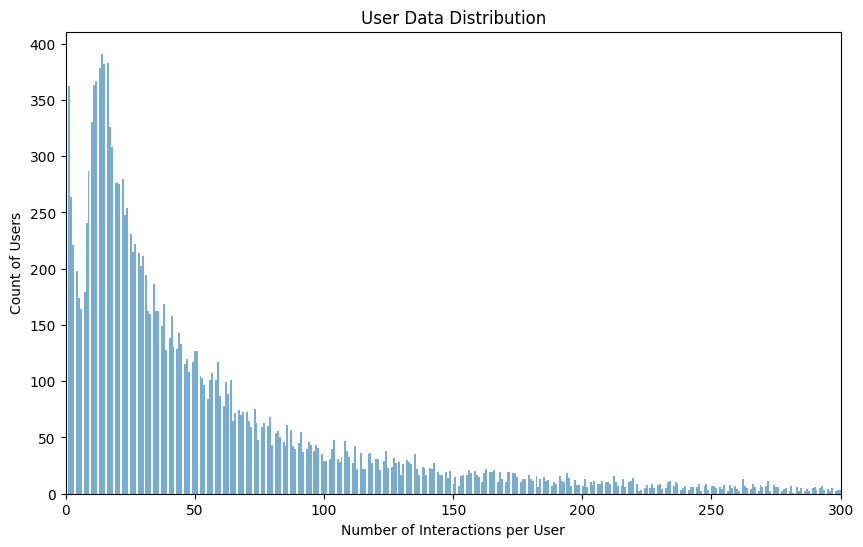

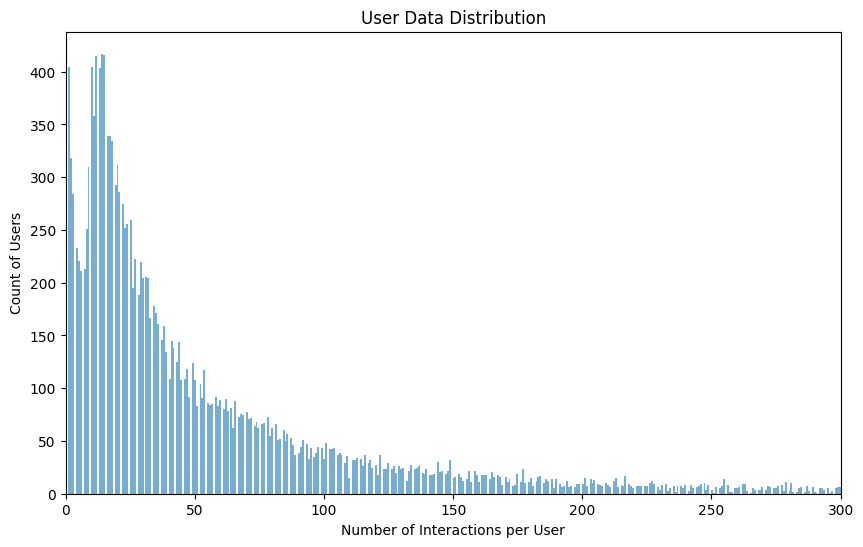

In [ ]:
def plot_user_distribution(df, max_interactions=None):
    user_counts = df['userId'].value_counts()
    plt.figure(figsize=(10, 6))
    if max_interactions:
        user_counts = user_counts[user_counts <= max_interactions]
    plt.hist(user_counts, bins=400, alpha=0.6)
    plt.title('User Data Distribution')
    plt.xlabel('Number of Interactions per User')
    plt.ylabel('Count of Users')
    if max_interactions:
        plt.xlim(0, max_interactions)
    plt.show()

# 예를 들어, 사용자당 최대 50회의 상호작용만 보고 싶은 경우:
plot_user_distribution(train_df, max_interactions=300)
plot_user_distribution(validation_df, max_interactions=300)
plot_user_distribution(test_df, max_interactions=300)

In [4]:
class BiasMF(torch.nn.Module):
    def __init__(self, params):
        super(BiasMF, self).__init__()
        self.num_users = params['num_users']
        self.num_items = params['num_items']
        self.latent_dim = params['latent_dim']
        self.mu = params['global_mean']

        self.user_embedding = torch.nn.Embedding(self.num_users, self.latent_dim)
        self.item_embedding = torch.nn.Embedding(self.num_items, self.latent_dim)

        self.user_bias = torch.nn.Embedding(self.num_users, 1)
        self.user_bias.weight.data = torch.zeros(self.num_users, 1).float()
        self.item_bias = torch.nn.Embedding(self.num_items, 1)
        self.item_bias.weight.data = torch.zeros(self.num_items, 1).float()

    def forward(self, user_indices, item_indices):
        user_vec = self.user_embedding(user_indices)
        item_vec = self.item_embedding(item_indices)
        dot = torch.mul(user_vec, item_vec).sum(dim=1)

        rating = dot + self.mu + self.user_bias(user_indices).view(-1) + self.item_bias(item_indices).view(-1) + self.mu

        return rating

In [5]:
params = {
    'num_users': 162541,
    'num_items': 51124,
    'latent_dim': 30,
    'global_mean': 3.0
}
# 모델 인스턴스 생성
model = BiasMF(params)

# 모델 상태 사전 로드
model.load_state_dict(torch.load('/content/drive/MyDrive/data/MF_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [9]:
user_index = torch.tensor([x for x in range(162530, 162541)])
item_index = torch.tensor([x for x in range(51113 ,51124)])

# 모델에 입력
rating_prediction1 = model(user_index, item_index)

print(rating_prediction1)

tensor([ 2.9711,  8.2210,  4.0468,  3.1535, 19.9654, -2.6274,  3.3258,  0.9188,
        16.5886,  6.0557, 11.2152], grad_fn=<AddBackward0>)
